In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import os
import torchvision 

In [2]:
from torch.utils.data import Dataset 
import cv2
import matplotlib.pyplot as plt
from xml.dom import minidom
from os.path import basename
import glob

In [3]:
def unpickle(file):
   import pickle
   with open(file, 'rb') as fo:
      dict = pickle.load(fo, encoding='bytes')
   return dict

In [ ]:
training=torchvision.datasets.ImageNet(root='/kaggle/input/imagenet-object-localization-challenge/ILSVRC', train=True, download=True)

In [4]:
def generate_noise(path,t,ct):
    img=cv2.imread(path)
    img=np.array(img)
    img=img/255.0
    
    epsilon=np.random.randn(*img.shape).astype(np.float32)
    noise = np.exp(-t / ct)
    noise=np.clip(noise,0,1)
    new_img=np.sqrt(noise)*img + np.sqrt(1-noise)*epsilon
    new_img=np.clip(new_img,0,1)
    
    return noise

In [3]:
xml_folder=r'/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Annotations/CLS-LOC/train'
train_folder=r'/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train/*'

In [3]:
train_folders = glob.glob('/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train/*')

In [4]:
folder=(train_folders[0]+'/*')

In [5]:
folder_name=glob.glob(folder)

In [ ]:
(folder_name)

for i in range(1,101):
    generate_noise(folder_name[0],0.0001,0.02,i,100)

In [50]:
class Diffusion(nn.Module):
    def __init__(self,batch) -> None:
        super().__init__()
        self.batch=batch
        self.time_embed = nn.Linear(1, 32).float()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3,3), stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.3)
 
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.conv3 = nn.Conv2d(32, 3, kernel_size=(3,3), stride=1, padding=1)

    def forward(self,x,t):

        t=t.view(self.batch,1).float()
        x = self.act1(self.conv1(x))
        x = self.drop1(x)
        t_emb = self.time_embed(t).unsqueeze(-1).unsqueeze(-1)
        x= x + t_emb
        x = self.act2(self.conv2(x))
        x = x+ t_emb
        x = self.conv3(x)
        return x

model = Diffusion(1)
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.1)
def generate(path,t,ct):
    img=cv2.imread(path)
    img=np.array(img)
    img=img/255.0
    
    epsilon=np.random.randn(*img.shape).astype(np.float32)
    noise = np.exp(-t / ct)
    noise=np.clip(noise,0,1)
    epsilon=np.clip(epsilon,0,1)
    new_img=np.sqrt(noise)*img + np.sqrt(1-noise)*epsilon
    new_img=np.clip(new_img,0,1)
    return torch.tensor(new_img,dtype=torch.float32).permute(2,0,1).unsqueeze(0), torch.tensor(epsilon,dtype=torch.float32).permute(2,0,1).unsqueeze(0)

def noising(path,t,epoch):
    new_img,error=generate(path,t,epoch)
    timestep = torch.tensor([t/epoch],dtype=torch.float32) 
    pred_error=model.forward(new_img,timestep)
    loss = loss_fn(pred_error, error)
    print(loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
def train(folder,epoch,T):
        for i in range(epoch):
            path=folder[np.random.randint(len(folder))]
            print(f"path : {path}, epoch: {i}")
            t=np.random.randint(T)
            noising(path,t,T)
        

In [51]:
train(folder_name,1000,100)

path : /kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train/n01531178/n01531178_13057.JPEG, epoch: 0
tensor(0.4308, grad_fn=<MseLossBackward0>)
path : /kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train/n01531178/n01531178_10755.JPEG, epoch: 1
tensor(0.3924, grad_fn=<MseLossBackward0>)
path : /kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train/n01531178/n01531178_11815.JPEG, epoch: 2
tensor(0.3941, grad_fn=<MseLossBackward0>)
path : /kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train/n01531178/n01531178_4654.JPEG, epoch: 3
tensor(0.3824, grad_fn=<MseLossBackward0>)
path : /kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train/n01531178/n01531178_14.JPEG, epoch: 4
tensor(0.3963, grad_fn=<MseLossBackward0>)
path : /kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train/n01531178/n01531178_5869.JPEG, epoch: 5
tensor(0.3968, grad_fn=<MseL

In [52]:
img,_=generate(folder_name[0],100,100)

In [53]:
test=img

In [54]:
def inference(img,ct):
    x=img
    for t in range(ct-1,-1,-1):
        t = torch.tensor([t/ct],dtype=torch.float32)
        noise = torch.exp(-t / ct)
        noise=torch.clip(noise,0,1)
        noise= noise.view(1, 1, 1, 1)
        eps=model(x,t)
        new_x= (x- torch.sqrt(1-noise)*eps)/(torch.sqrt(noise))
        x=new_x
    return new_x

In [ ]:
fin_img=inference(test,100)

In [ ]:
fin_img

In [39]:
import torchvision.transforms.functional as TF
from PIL import Image

In [40]:
image_tensor = torch.clamp(fin_img, 0, 1)

In [46]:
img1=cv2.imread(folder_name[0])

In [49]:
img1

array([[[ 45, 186, 123],
        [ 53, 190, 128],
        [ 58, 188, 127],
        ...,
        [ 78, 167, 117],
        [ 80, 172, 121],
        [ 89, 181, 130]],

       [[ 56, 183, 121],
        [ 47, 176, 115],
        [ 47, 176, 119],
        ...,
        [ 83, 178, 128],
        [ 77, 180, 129],
        [ 82, 187, 138]],

       [[ 50, 175, 106],
        [ 44, 170, 105],
        [ 47, 175, 116],
        ...,
        [ 89, 189, 129],
        [ 75, 183, 124],
        [ 73, 186, 128]],

       ...,

       [[ 78, 188, 140],
        [ 77, 186, 138],
        [ 77, 185, 139],
        ...,
        [ 87, 182, 148],
        [ 88, 184, 148],
        [ 86, 184, 148]],

       [[ 89, 191, 136],
        [ 78, 182, 129],
        [ 73, 183, 131],
        ...,
        [ 92, 185, 148],
        [ 89, 186, 146],
        [ 87, 187, 145]],

       [[ 92, 191, 129],
        [ 81, 186, 123],
        [ 87, 202, 139],
        ...,
        [ 85, 181, 134],
        [ 79, 182, 131],
        [ 77, 183, 130]]

In [44]:
img_tensor

tensor([[[0.6688, 0.0000, 0.0000,  ..., 0.1804, 0.0000, 0.3042],
         [1.0000, 0.0000, 0.0754,  ..., 0.0000, 0.0242, 0.2287],
         [0.8401, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.5889],
         ...,
         [1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.5467],
         [0.7735, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.6393],
         [0.8327, 1.0000, 0.3841,  ..., 1.0000, 0.3811, 0.7275]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0257, 0.6401],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000],
         [0.0000, 0.0000, 0.0590,  ..., 0.0000, 0.0504, 1.0000],
         [0.0000, 0.9274, 0.7631,  ..., 0.6340, 1.0000, 1.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.2404],
         [0.0790, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.1478],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.

In [41]:
img_tensor
img_tensor = img_tensor.squeeze(0).cpu()  # remove batch dimension
img_pil = TF.to_pil_image(img_tensor) 

In [42]:
img_pil.save("output.png")

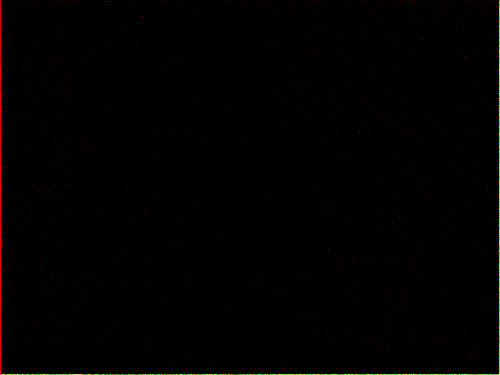

In [43]:
img_pil